<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/main/NER/bert/bert_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/

In [ ]:
# Get the raw dataset

!curl -s -LO https://github.com/MahmooudTaha/NLP-2019/raw/master/ner_dataset.csv.zip
!unzip -o ner_dataset.csv.zip
!rm -f ner_dataset.csv.zip


import pandas as pd


class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

df = pd.read_csv("/content/ner_dataset.csv", encoding="Windows-1252").fillna(method="ffill")

getter = SentenceGetter(df)

sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
labels = [[s[2] for s in sentence] for sentence in getter.sentences]


Archive:  ner_dataset.csv.zip
  inflating: ner_dataset.csv         


In [ ]:
!pip install -U transformers
!pip install -U seqeval

     |████████████████████████████████| 1.9MB 21.1MB/s 
     |████████████████████████████████| 890kB 43.9MB/s 
     |████████████████████████████████| 3.2MB 44.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=ad07283dd9458e33bd7d837064885935f5907a76540753505e0dfe94b9548f32
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 51kB 7.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16172 sha256=38aab20bcff976df7779fee6d550463d29fc1e330cce2026f82d973a81b7dd3a
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [ ]:
import numpy as np
from tqdm import trange

import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from seqeval.metrics import f1_score, accuracy_score, classification_report


def visualize_loss(loss_values, validation_loss_values):
  import matplotlib.pyplot as plt
  %matplotlib inline
  import seaborn as sns

  # Use plot styling from seaborn.
  sns.set(style="darkgrid")
  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12, 6)
  # Plot the learning curve.
  print("Training loss: {}".format(loss_values))
  print("Validation loss: {}".format(validation_loss_values))
  plt.plot(loss_values, 'b-o', label="training loss")
  plt.plot(validation_loss_values, 'r-o', label="validation loss")
  # Label the plot.
  plt.title("Learning curve")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/MyDrive/NER/Model/checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


class NERBertModel:
  def __init__(
      self,
      data_texts,
      data_tags,
      pretrained_model="bert-base-cased",
      max_len=75,
      batch_size=32,
      epochs=20,
      max_grad_norm=1.0,
      test_size=0.1
      ):
    self.random_state = 7
    np.random.seed(self.random_state)
    self.data_texts = data_texts
    self.data_tags = data_tags
    # self.test_data_texts = test_data_texts
    # self.test_data_tags = test_data_tags
    self.pretrained_model = pretrained_model
    self.max_len = max_len
    self.batch_size = batch_size
    self.epochs = epochs
    self.max_grad_norm = max_grad_norm
    self.test_size = test_size

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.n_gpu = torch.cuda.device_count()
    
    self.tag_values, self.tag2idx = self.get_tag_values(self.data_tags)
    self.tokenizer = BertTokenizer.from_pretrained(self.pretrained_model, do_lower_case=False)
    self.tokenized_texts, self.tokenized_tags = self.get_tokenized_texts_tags(self.data_texts, self.data_tags)
    self.input_ids, self.input_tags = self.get_pad_sequences(self.tokenized_texts, self.tokenized_tags, self.tag2idx)
    self.attention_masks = [[float(i != 0.0) for i in ii] for ii in self.input_ids]
    self.tr_inputs, self.val_inputs, self.tr_tags, self.val_tags, self.tr_masks, self.val_masks = self.split_dataset(self.input_ids, self.input_tags, self.attention_masks, self.test_size)

  def get_tag_values(self, data_tags):
    # Remove duplicate tags
    n_l = []
    for l in data_tags:
      for i in l:
        n_l.append(i)
    # tag_values = list(set(n_l))
    tag_values = list(dict.fromkeys(n_l))
    tag_values.append("PAD")
    tag2idx = {t: i for i, t in enumerate(tag_values)}
    print("tag_values: {}".format(tag_values))
    print("tag2idx: {}".format(tag2idx))
    return tag_values, tag2idx

  def tokenize_and_preserve_tags(self, sentence, text_tags):
    # Now we tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens.
    # For example 'gunships' will be split in the two tokens 'guns' and '##hips'.
    # We have to deal with the issue of splitting our token-level tags to related subtokens.
    # In practice you would solve this by a specialized data structure based on tag spans, but for simplicity I do it explicitly here.
    tokenized_sentence = []
    tags = []
    for word, tag in zip(sentence, text_tags):
        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = self.tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)
        # Add the same tag to the new list of tags `n_subwords` times
        tags.extend([tag] * n_subwords)
    return tokenized_sentence, tags

  def get_tokenized_texts_tags(self, data_texts, data_tags):
    tokenized_texts_and_tags = [self.tokenize_and_preserve_tags(sent, tags) for sent, tags in zip(data_texts, data_tags)]
    tokenized_texts = [token_tag_pair[0] for token_tag_pair in tokenized_texts_and_tags]
    tokenized_tags = [token_tag_pair[1] for token_tag_pair in tokenized_texts_and_tags]
    return tokenized_texts, tokenized_tags

  def get_pad_sequences(self, tokenized_texts, tokenized_tags, tag2idx):
    # We cut and pad the token and label sequences to our desired length.
    input_ids = pad_sequences(
        [self.tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
        maxlen=self.max_len,
        dtype="long",
        value=0.0,
        truncating="post",
        padding="post"
        )
    input_tags = pad_sequences(
        [[tag2idx.get(l) for l in lab] for lab in tokenized_tags],
        maxlen=self.max_len,
        dtype="long",
        value=tag2idx["PAD"],
        truncating="post",
        padding="post"
        )
    return input_ids, input_tags

  def split_dataset(self, input_ids, input_tags, attention_masks, test_size=0.1):
    tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(
        input_ids,
        input_tags,
        random_state=self.random_state,
        test_size=test_size
        )
    tr_masks, val_masks, _, _ = train_test_split(
      attention_masks,
      input_ids,
      random_state=self.random_state,
      test_size=test_size
      )
    return tr_inputs, val_inputs, tr_tags, val_tags, tr_masks, val_masks
  
  def build_model(self):
    # Since we’re operating in pytorch, we have to convert the dataset to torch tensors.
    tr_inputs = torch.tensor(self.tr_inputs)
    val_inputs = torch.tensor(self.val_inputs)
    tr_tags = torch.tensor(self.tr_tags)
    val_tags = torch.tensor(self.val_tags)
    tr_masks = torch.tensor(self.tr_masks)
    val_masks = torch.tensor(self.val_masks)

    # The last step is to define the dataloaders.
    # We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.
    train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size)
    valid_data = TensorDataset(val_inputs, val_masks, val_tags)
    valid_sampler = SequentialSampler(valid_data)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=self.batch_size)

    model = BertForTokenClassification.from_pretrained(
        self.pretrained_model,
        num_labels=len(self.tag2idx),
        output_attentions = False,
        output_hidden_states = False
        )
    
    # We have to pass the model parameters to the GPU.
    model.cuda()

    # Before we can start the fine-tuning process, we have to setup the optimizer and add the parameters it should update.
    # A common choice is the `AdamW` optimizer. We also add some weight_decay as regularization to the main `weight matrices`.
    # If you have limited resources, you can also try to just train the linear classifier on top of BERT and keep all other weights fixed.
    # This will still give you a good performance.
    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "gamma", "beta"]
        optimizer_grouped_parameters = [
            {"params": [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], "weight_decay_rate": 0.01},
            {"params": [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], "weight_decay_rate": 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=3e-5,
        eps=1e-8
    )

    # We also add a scheduler to linearly reduce the learning rate throughout the epochs.
    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * self.epochs
    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    return model, scheduler, optimizer, train_dataloader, valid_dataloader

  def train(self, checkpoint_path="checkpoint.pt", earlystopping_patience=3, loss_chart=False):
    model, scheduler, optimizer, train_dataloader, valid_dataloader = self.build_model()

    # we can finetune the model. A few epochs should be enougth. The paper suggest 3-4 epochs.
    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []

    # Initialize the early_stopping object
    early_stopping = EarlyStopping(patience=earlystopping_patience, path=checkpoint_path, verbose=True)

    for _ in trange(self.epochs, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in enumerate(train_dataloader):
            # add batch to gpu
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # forward pass
            # This will return the loss (rather than the model output)
            # because we have provided the `labels`.
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels
                )
            # get the loss
            loss = outputs[0]
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # track train loss
            total_loss += loss.item()
            # Clip the norm of the gradient
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=self.max_grad_norm)
            # update parameters
            optimizer.step()
            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in valid_dataloader:
            batch = tuple(t.to(self.device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels
                    )
            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
            true_labels.extend(label_ids)
        
        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {}".format(eval_loss))

        pred_tags = []
        for p, l in zip(predictions, true_labels):
          per_doc_pred_tags = []
          for p_i, l_i in zip(p, l):
            if self.tag_values[l_i] != "PAD":
              per_doc_pred_tags.append(self.tag_values[p_i])
          pred_tags.append(per_doc_pred_tags)

        valid_tags = []
        for l in true_labels:
          per_doc_valid_tags = []
          for l_i in l:
            if self.tag_values[l_i] != "PAD":
              per_doc_valid_tags.append(self.tag_values[l_i])
          valid_tags.append(per_doc_valid_tags)

        print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
        print("Validation F1-Score: {}".format(f1_score(valid_tags, pred_tags)))
        print(classification_report(valid_tags, pred_tags))
        print("")

        # Early_stopping needs the validation loss to check if it has decresed, and if it has, it will make a checkpoint of the current model
        early_stopping(eval_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(checkpoint_path))

    # Save entire model
    torch.save(model, checkpoint_path)

    if loss_chart is True:
      visualize_loss(loss_values, validation_loss_values)
    return model


tag_values: ['O', 'B-geo', 'B-gpe', 'B-tim', 'B-org', 'I-geo', 'B-per', 'I-per', 'I-org', 'I-tim', 'B-art', 'I-art', 'B-nat', 'I-gpe', 'I-nat', 'B-eve', 'I-eve', 'PAD']
tag2idx: {'O': 0, 'B-geo': 1, 'B-gpe': 2, 'B-tim': 3, 'B-org': 4, 'I-geo': 5, 'B-per': 6, 'I-per': 7, 'I-org': 8, 'I-tim': 9, 'B-art': 10, 'I-art': 11, 'B-nat': 12, 'I-gpe': 13, 'I-nat': 14, 'B-eve': 15, 'I-eve': 16, 'PAD': 17}


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Average train loss: 0.19070992665468894
Validation loss: 0.13170205960671108
Validation Accuracy: 0.9591638347928375
Validation F1-Score: 0.8250634462238557
              precision    recall  f1-score   support

         art       0.12      0.02      0.04        86
         eve       0.38      0.25      0.30        40
         geo       0.84      0.91      0.87      6117
         gpe       0.95      0.91      0.93      1769
         nat       0.23      0.31      0.27        45
         org       0.76      0.70      0.73      3701
         per       0.75      0.85      0.79      3030
         tim       0.87      0.83      0.85      2183

   micro avg       0.82      0.83      0.83     16971
   macro avg       0.61      0.60      0.60     16971
weighted avg       0.81      0.83      0.82     16971


Validation loss decreased (inf --> 0.131702).  Saving model ...


Epoch:   1%|          | 1/100 [09:52<16:17:06, 592.19s/it]

Average train loss: 0.11108684265437924
Validation loss: 0.12345050357282161
Validation Accuracy: 0.9604055025486864
Validation F1-Score: 0.8280232456268435
              precision    recall  f1-score   support

         art       0.17      0.13      0.15        86
         eve       0.27      0.25      0.26        40
         geo       0.86      0.89      0.88      6117
         gpe       0.95      0.92      0.94      1769
         nat       0.26      0.40      0.31        45
         org       0.74      0.74      0.74      3701
         per       0.80      0.79      0.80      3030
         tim       0.81      0.86      0.84      2183

   micro avg       0.82      0.84      0.83     16971
   macro avg       0.61      0.62      0.61     16971
weighted avg       0.82      0.84      0.83     16971


Validation loss decreased (0.131702 --> 0.123451).  Saving model ...


Epoch:   2%|▏         | 2/100 [19:43<16:06:46, 591.90s/it]

Average train loss: 0.0824227248662993
Validation loss: 0.12927884101867676
Validation Accuracy: 0.9615736505032022
Validation F1-Score: 0.8359613206725325


Epoch:   3%|▎         | 3/100 [29:33<15:56:02, 591.36s/it]

              precision    recall  f1-score   support

         art       0.28      0.17      0.22        86
         eve       0.62      0.33      0.43        40
         geo       0.86      0.91      0.88      6117
         gpe       0.95      0.92      0.94      1769
         nat       0.41      0.29      0.34        45
         org       0.74      0.76      0.75      3701
         per       0.78      0.82      0.80      3030
         tim       0.85      0.86      0.85      2183

   micro avg       0.82      0.85      0.84     16971
   macro avg       0.69      0.63      0.65     16971
weighted avg       0.82      0.85      0.83     16971


EarlyStopping counter: 1 out of 3
Average train loss: 0.061134057904450735
Validation loss: 0.13968060319622358
Validation Accuracy: 0.9609609854920925
Validation F1-Score: 0.83431127636089


Epoch:   4%|▍         | 4/100 [39:23<15:45:23, 590.87s/it]

              precision    recall  f1-score   support

         art       0.27      0.22      0.24        86
         eve       0.40      0.25      0.31        40
         geo       0.84      0.92      0.88      6117
         gpe       0.95      0.93      0.94      1769
         nat       0.82      0.31      0.45        45
         org       0.78      0.72      0.75      3701
         per       0.77      0.83      0.80      3030
         tim       0.83      0.86      0.84      2183

   micro avg       0.82      0.85      0.83     16971
   macro avg       0.71      0.63      0.65     16971
weighted avg       0.82      0.85      0.83     16971


EarlyStopping counter: 2 out of 3
Average train loss: 0.04624773723986676
Validation loss: 0.1495598182330529
Validation Accuracy: 0.9623987060514966
Validation F1-Score: 0.8414988944489701
              precision    recall  f1-score   support

         art       0.22      0.36      0.27        86
         eve       0.47      0.42      0.45      

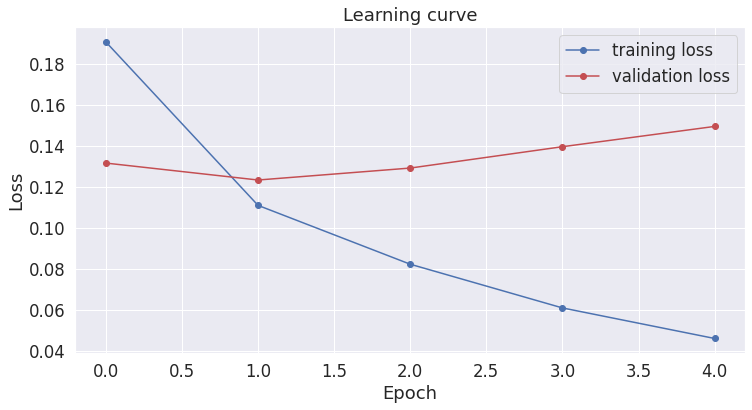

In [ ]:
bert_model = NERBertModel(
    sentences,
    labels,
    # https://huggingface.co/transformers/pretrained_models.html
    pretrained_model="bert-base-cased",
    # pretrained_model="bert-large-cased",
    # pretrained_model="bert-large-cased-whole-word-masking",
    max_len=75,
    batch_size=32,
    epochs=100,
    max_grad_norm=1.0,
    test_size=0.1
    )

model = bert_model.train(checkpoint_path="checkpoint.pt", earlystopping_patience=3, loss_chart=True)